Step 1: Scaling Target Variable

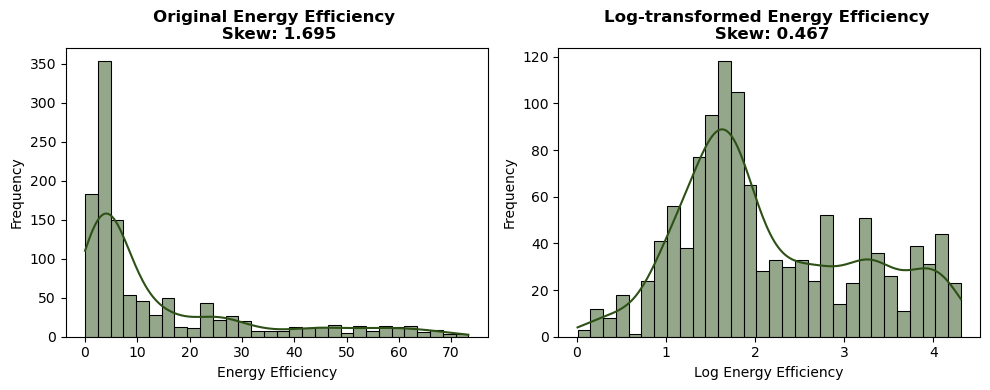

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("imputed_df.csv")
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

#original plot
sns.histplot(data=df, x='Energy Efficiency [GFlops/Watts]', ax=axes[0], bins=30, kde=True, color='#2D5016')
axes[0].set_title(f'Original Energy Efficiency \n Skew: {df['Energy Efficiency [GFlops/Watts]'].skew():.3f}', fontweight='semibold')
axes[0].set_xlabel('Energy Efficiency')
axes[0].set_ylabel('Frequency')

#log plot
df['log_energy'] = np.log1p(df['Energy Efficiency [GFlops/Watts]'])
sns.histplot(data=df, x='log_energy', ax=axes[1], bins=30, kde=True, color='#2D5016')
axes[1].set_title(f'Log-transformed Energy Efficiency \n Skew: {df['log_energy'].skew():.3f}', fontweight='semibold')
axes[1].set_xlabel('Log Energy Efficiency')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Step 2: Choose what variables will work well for modelling.

Continuous variables i'll use:
Total Cores
Rmax [TFlop/s]
Rpeak [TFlop/s]
Power (kW)
Processor Speed (MHz)

Discrete/Categorical variables (with encoding):

Year (technically discrete, can treat as continuous)
Manufacturer
Country
Segment
Processor Generation
System Family
Accelerator/Co-Processor

In [13]:
df.isnull().sum()

Manufacturer                          0
Country                               0
Segment                               0
Processor Technology                  0
Operating System                      0
Accelerator/Co-Processor            661
Processor Generation                  0
System Family                         0
Interconnect Family                   0
Continent                             0
Accelerator/Co-Processor Cores        0
Power (kW)                            0
TOP500 Rank                           0
Year                                  0
Total Cores                           0
Rmax [TFlop/s]                        0
Rpeak [TFlop/s]                       0
Energy Efficiency [GFlops/Watts]      0
Processor Speed (MHz)                 0
source_year                           0
log_energy                            0
dtype: int64

In [15]:
continuous_cols = ['Total Cores', 'Rmax [TFlop/s]', 'Rpeak [TFlop/s]', 
                   'Power (kW)', 'Processor Speed (MHz)', 'Year']
correlation_matrix = df[continuous_cols + ['Energy Efficiency [GFlops/Watts]']].corr()
correlation_matrix

,Total Cores,Rmax [TFlop/s],Rpeak [TFlop/s],Power (kW),Processor Speed (MHz),Year,Energy Efficiency [GFlops/Watts]
Total Cores,1.000000,0.752739,0.739883,0.854829,-0.152418,0.019960,0.123142
Rmax [TFlop/s],0.752739,1.000000,0.991576,0.726403,-0.058457,0.157403,0.288121
Rpeak [TFlop/s],0.739883,0.991576,1.000000,0.721270,-0.059049,0.152066,0.273379
Power (kW),0.854829,0.726403,0.721270,1.000000,-0.114107,-0.086915,0.011628
Processor Speed (MHz),-0.152418,-0.058457,-0.059049,-0.114107,1.000000,0.031462,0.105322
Year,0.019960,0.157403,0.152066,-0.086915,0.031462,1.000000,0.636809
Energy Efficiency [GFlops/Watts],0.123142,0.288121,0.273379,0.011628,0.105322,0.636809,1.000000


High correlation with target : Year, then Rmax
High correlation between predictors (multicollinearity): Rmax and Rpeak

In [16]:
df[continuous_cols].skew()

Total Cores              6.387200
Rmax [TFlop/s]           9.425485
Rpeak [TFlop/s]          9.963958
Power (kW)               5.286962
Processor Speed (MHz)    0.318222
Year                    -0.284299
dtype: float64

In [27]:
print(f'Skew before for energy efficiency:  {df['Energy Efficiency [GFlops/Watts]'].skew():.3f}')
print(f'Skew after for energy efficiency:  {df['log_energy'].skew():.3f}')

Skew before for energy efficiency:  1.695
Skew after for energy efficiency:  0.467


In [30]:
df['log_total_cores'] = np.log1p(df['Total Cores'])
df['log_rmax'] = np.log1p(df['Rmax [TFlop/s]'])
df['log_rpeak'] = np.log1p(df['Rpeak [TFlop/s]'])
df['log_power'] = np.log1p(df['Power (kW)'])
log_continuous_cols = ['log_total_cores', 'log_rmax', 'log_rpeak', 'log_power']
df[log_continuous_cols].skew()

log_total_cores    1.040402
log_rmax           1.730817
log_rpeak          1.759996
log_power          0.183219
dtype: float64

In [31]:
continuous_features = ['log_total_cores', 'log_rmax', 'log_rpeak', 
                       'log_power', 'Processor Speed (MHz)', 'Year']

correlation_data = df[continuous_features + ['log_energy']]
correlation_matrix = correlation_data.corr()

print(correlation_matrix['log_energy'].sort_values(ascending=False))

log_energy               1.000000
Year                     0.731812
log_rmax                 0.516364
log_rpeak                0.501280
Processor Speed (MHz)    0.129590
log_total_cores         -0.016107
log_power               -0.433975
Name: log_energy, dtype: float64


In [32]:
print(df[['log_rmax', 'log_rpeak']].corr())

           log_rmax  log_rpeak
log_rmax   1.000000   0.976185
log_rpeak  0.976185   1.000000


In [33]:
X = df[['Year', 'log_total_cores', 'log_rmax', 'log_power', 'Processor Speed (MHz)']]
y = df['log_energy']

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [37]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predictions
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Metrics
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train R²: {r2_train:.3f}")
print(f"Test R²: {r2_test:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

Train R²: 0.961
Test R²: 0.972
MAE: 0.103
RMSE: 0.166


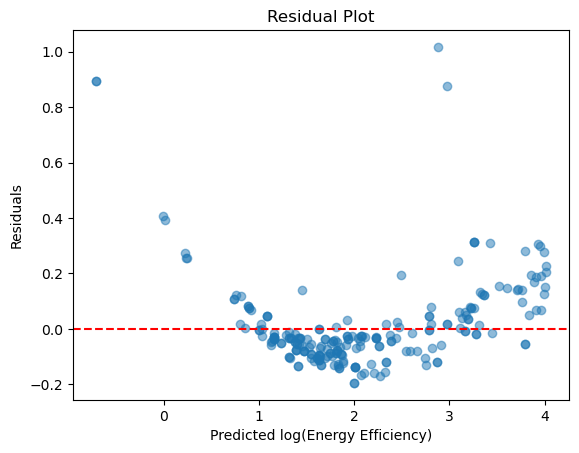

In [38]:
residuals = y_test - y_pred_test

plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted log(Energy Efficiency)')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()